In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
df = pd.read_csv("../data/falls_after_step1.csv", delimiter=",")
df = df.drop(columns=[col for col in ['procedure', 'diagnosis', 'transfer', 'sex'] if col in df.columns])
#df = pd.read_csv("../data/falls_after_PCA.csv", delimiter=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39985 entries, 0 to 39984
Data columns (total 40 columns):
 #   Column                                            Non-Null Count  Dtype
---  ------                                            --------------  -----
 0   fallen                                            39985 non-null  bool 
 1   age                                               39985 non-null  int64
 2   c_zriserh1                                        39985 non-null  bool 
 3   decubitus-at_the_moment                           39985 non-null  bool 
 4   bed_mobility-impairment                           39985 non-null  bool 
 5   bed_mobility-jones                                39985 non-null  int64
 6   bed_mobility-skin_condition                       39985 non-null  bool 
 7   transfer-impairment                               39985 non-null  bool 
 8   medical_items                                     39985 non-null  bool 
 9   medical_items-arm_or_leg_splint        

In [29]:
# 2. Features und Zielvariable trennen
X = df.drop("fallen", axis=1)
y = df["fallen"]

In [30]:
# 3. Trainings- und Testdaten splitten
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


🔍 Decision Tree mit Schwelle 0.3
              precision    recall  f1-score   support

       False       1.00      0.97      0.99      7978
        True       0.08      0.95      0.15        19

    accuracy                           0.97      7997
   macro avg       0.54      0.96      0.57      7997
weighted avg       1.00      0.97      0.98      7997



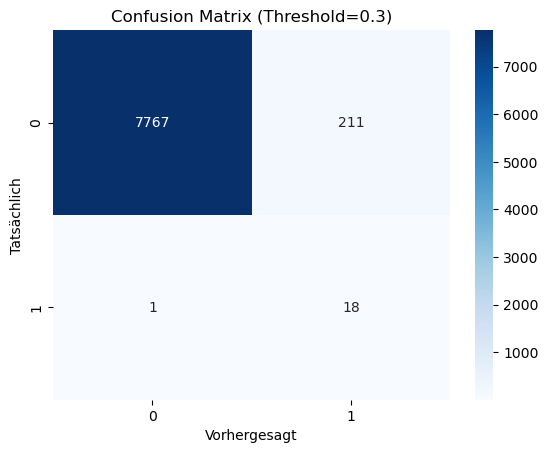

In [31]:
# ------------------------------------------
# 4. Modell 1: Einfacher Entscheidungsbaum

# 1. Modell definieren
tree = DecisionTreeClassifier(
    max_depth=5,               # etwas tiefer als vorher
    class_weight="balanced",
    random_state=42
)
tree.fit(X_train, y_train)

# 2. Wahrscheinlichkeiten vorhersagen
y_probs = tree.predict_proba(X_test)[:, 1]  # Wahrscheinlichkeit für Klasse 1

# 3. Eigene Schwelle setzen (z. B. 0.3 statt 0.5 → "früher" warnen)
threshold = 0.3
y_pred_thresh = (y_probs >= threshold).astype(int)

# 4. Auswertung
print(f"🔍 Decision Tree mit Schwelle {threshold}")
print(classification_report(y_test, y_pred_thresh))

sns.heatmap(confusion_matrix(y_test, y_pred_thresh), annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix (Threshold={threshold})")
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.show()


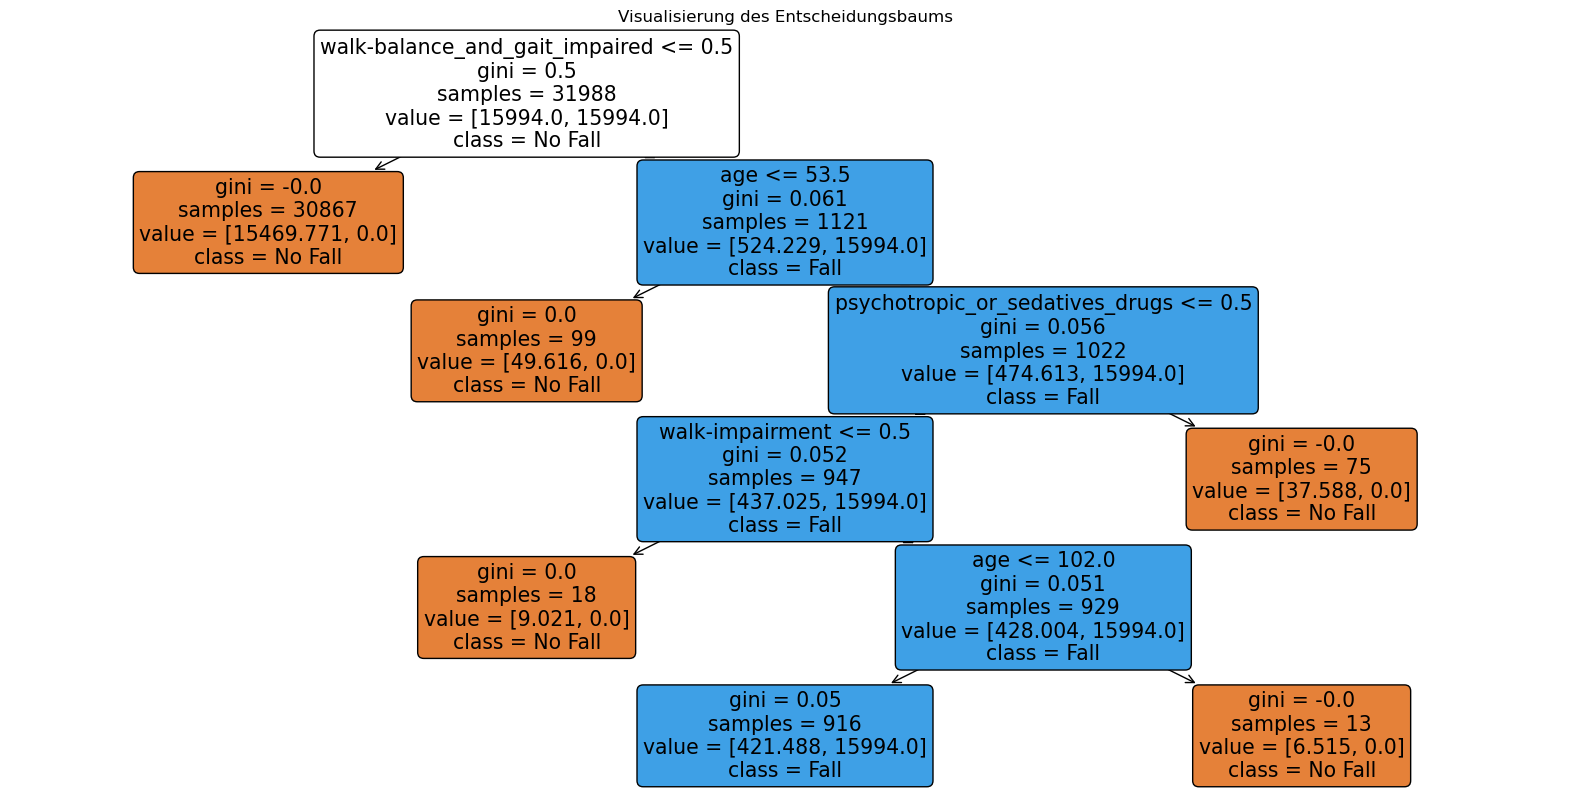

In [39]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(tree, 
          feature_names=X.columns, 
          class_names=["No Fall", "Fall"], 
          filled=True, 
          rounded=True)
plt.title("Visualisierung des Entscheidungsbaums")
plt.show()


🔍 Random Forest mit Schwelle 0.09
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      7978
        True       0.20      0.68      0.31        19

    accuracy                           0.99      7997
   macro avg       0.60      0.84      0.65      7997
weighted avg       1.00      0.99      0.99      7997



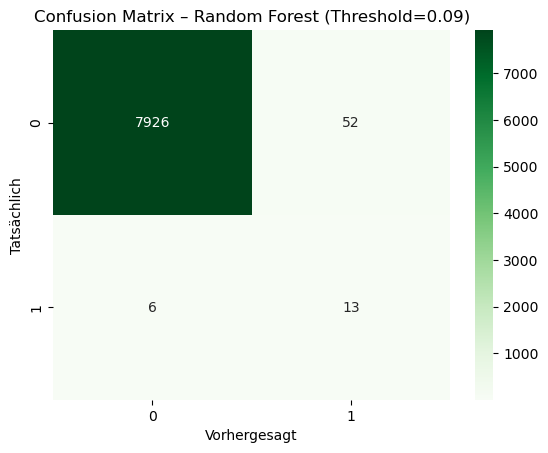

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Modell definieren & trainieren
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 2. Wahrscheinlichkeit für Klasse 1 vorhersagen
y_probs_rf = rf.predict_proba(X_test)[:, 1]

# 3. Eigene Schwelle setzen (z. B. 0.01)
threshold = 0.09
y_pred_thresh_rf = (y_probs_rf >= threshold).astype(int)

# 4. Auswertung
print(f"🔍 Random Forest mit Schwelle {threshold}")
print(classification_report(y_test, y_pred_thresh_rf))

sns.heatmap(confusion_matrix(y_test, y_pred_thresh_rf), annot=True, fmt="d", cmap="Greens")
plt.title(f"Confusion Matrix – Random Forest (Threshold={threshold})")
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.show()


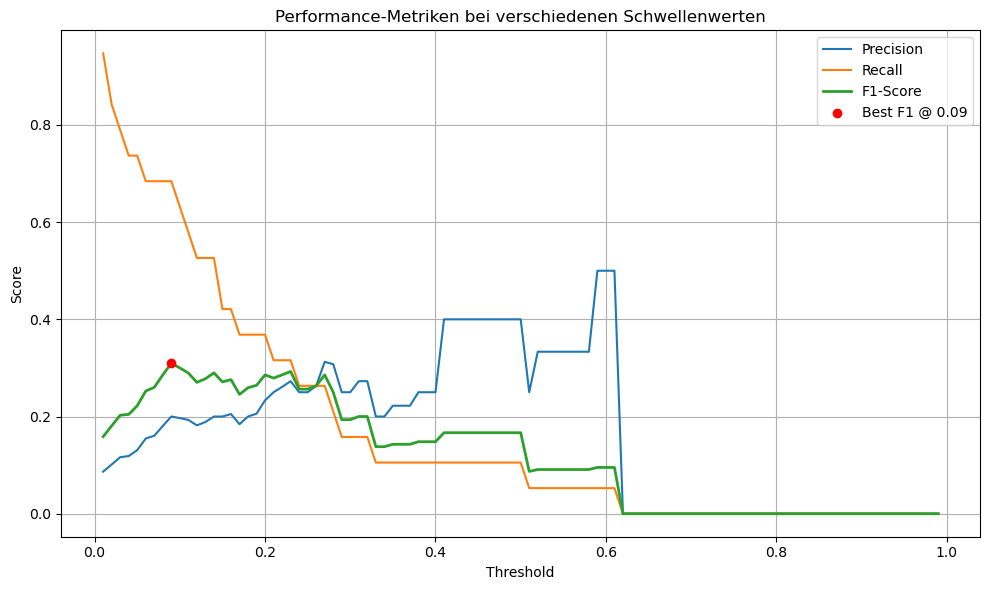

🔍 Beste Schwelle nach F1-Score: 0.09 mit F1 = 0.310


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Wahrscheinlichkeiten für Klasse 1
y_probs = rf.predict_proba(X_test)[:, 1]

# Schwellen
thresholds = np.arange(0.01, 1.00, 0.01)
precisions, recalls, f1_scores = [], [], []

# Metriken berechnen
for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Beste Schwelle nach F1
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score', linewidth=2)

# Punkt markieren
plt.scatter(best_thresh, best_f1, color='red', label=f'Best F1 @ {best_thresh:.2f}', zorder=5)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Performance-Metriken bei verschiedenen Schwellenwerten")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Ausgabe
print(f"🔍 Beste Schwelle nach F1-Score: {best_thresh:.2f} mit F1 = {best_f1:.3f}")


In [50]:
import shap

# 1. SHAP-Werte neu berechnen
explainer = shap.Explainer(rf, X_train.astype(float))
shap_values = explainer(X_test.astype(float))

 99%|===================| 15853/15994 [01:28<00:00]        

In [51]:
# 2. Nur Klasse "1" extrahieren
shap_class_1 = shap.Explanation(
    values=shap_values.values[:, :, 1],  # Klasse 1
    base_values=shap_values.base_values[:, 1],
    data=shap_values.data,
    feature_names=shap_values.feature_names
)

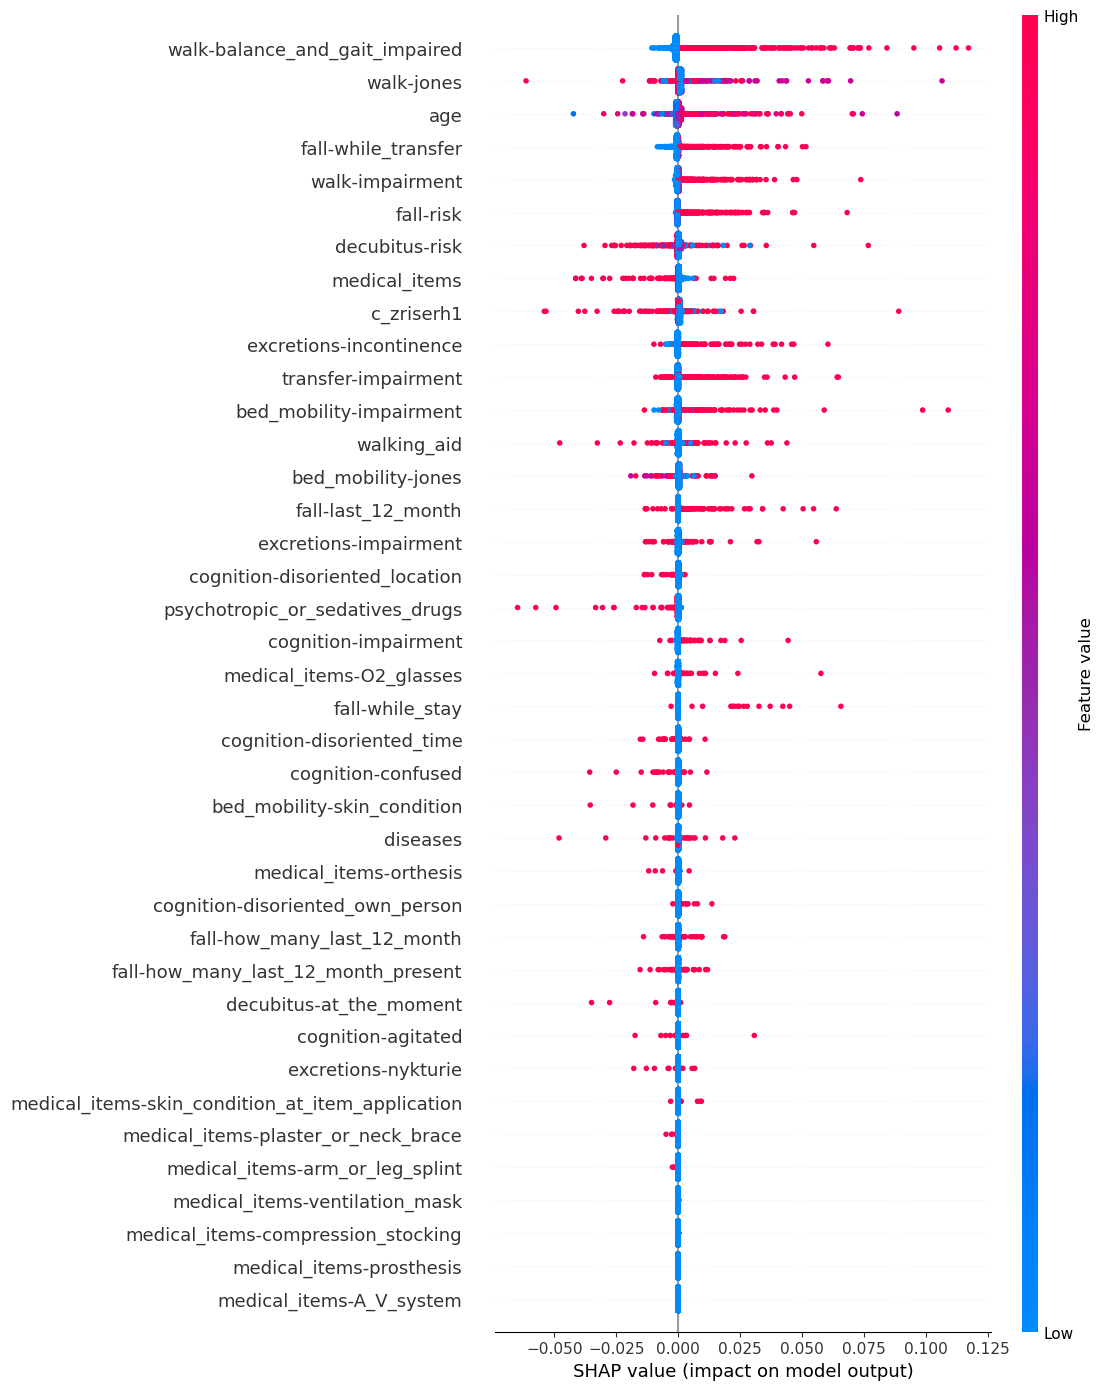

In [55]:
# 3. Visualisieren
#shap.plots.bar(shap_class_1, max_display=39)
shap.plots.beeswarm(shap_class_1, max_display=39)